# Solar System Cost Analysis 

## Objective 

How much an energy system cost is a very important standard to judge if this solar storage setup is good or not? In this example, I will discover the power of mathematical optimization in addressing a common energy industry problem: solar storage setup cost analysis. 

The current ERCOT solar grid will be evaluated based on the historical Houston Hub settlement point price along with the normalized solar output in 2019.

---
## Problem Description

In this problem, a renewable energy developer want to make an investment to a new solar farm in Houston. However, they want to know what kind of configurations is most economical and beneficial for them. Therefore, an analysis on how much they would earn in 2019 by comparing three different configurations is implemented. Here, those three configurations are respectively (1) standalone storage system; (2) solar+storage system (3) standalone solar. 

The data set of 8760 hourly solar irradiance and Houston hub electricity price is as follows:

| weather year hour beginning | Solar Shape (Normalized) | Houston hub Settlement Point Energy Price (\$/MWh) |
| --- | --- | ---| 
| 1/1/2019 0:00| 0 | 14.1900	 | 
| 1/1/2019 1:00 | 0 | 15.1825	 |
| 1/1/2019 2:00 | 0 | 15.5300 | 


(1) Proposed Installation (Standalone Solar) Setting:

| Parameter | Value| Unit |
| --- | --- | --- | 
| Solar Size | 300 |  MW | 
| Inverter Capacity | 220 | MW |
| Solar System Cost | \$1.45 | \$/Watt-DC |


(2) Proposed Installation (Standalone Storage) Setting:

| Parameter | Value| Unit |
| --- | --- | --- | 
| Storage Capacity | 50 |  MW | 
| Storage Energy | 200 | MWh |
| Round Trip Efficiency | 85\% |   |
| Storage System Cost | \$350 | \$/KWh  |

(3) Proposed Installation (Combined Solar + Storage System) Setting:

| Parameter | Value| Unit |
| --- | --- | --- | 
| Solar Size | 300 |  MW | 
| Inverter Capacity | 220 | MW |
| Storage Capacity | 50 |  MW |
| Storage Energy | 200 | MWh  |
| Round Trip Efficiency | 85\% |  |
| Solar System Cost | \$1.35 | \$/Watt-DC  |
| Storage System Cost | \$325 | \$/KWh  |

---

## Model Formulation

### Parameters
$\text{RTM} \in \mathbb{R}^+$: Real Time Market Settlement Point Price  \$/KWh.

normSolar: Normalized Solar Shape.

timeStamp: hours begining in year 2019.

Life cycle of Solar Pannel: assume 30 years in service.

Life cycle of Battery Storage: assume 10 years in service.

$\eta$: Round Trip Efficiency

$SOC_t$: State of Charge at hour t

$AC_t$: AC output of solar energy at hour t

$DC_t$: DC output of solar energy at hour t

### Decision Variables

$SOC_t$: State of Charge at hour t

$E_t^{in}$: Energy delivered to the storage at hour t

$E_t^{out}$: Energy discharged to the grid at hour t

$E_t^{Gin}$ : Energy charged to the storage from grid at hour t

$E_t^{BoutG}$ : Energy discharged to the grid from storage at hour t

$E_t^{Sin}$ : Energy delivered to the storage from solar at hour t

$E_t^{SoutG}$   : Energy delivered to the grid from solar at hour t


### Objective Function

- **𝑅𝑒𝑣𝑒𝑛𝑢𝑒**: Maximize the revenue of solar system (in USD).

For a standalone solar system (Assume 30 years solar plant life):

\begin{equation}
\text{Maximize}  AC_t \times P_t
\end{equation}

For a standalone storage system (Assume 10 years storage life):

\begin{equation}
\text{Maximize}  (E_t^{out}- E_t^{in}) \times P_t
\end{equation}

For a solar and storage system (Assume 10 years storage life, 30 years solar plant life):

\begin{equation}
\text{Maximize} (E_t^{BoutG}+E_t^{SoutG})∗P_t− E_t^{Gin}∗P_t
\end{equation}

### Constraints

For a standalone solar system:

$DC_t$ = 300*normSolar

$AC_t$ = min(220, $DC_t$)

For a standalone storage system:
(1) at any time t, the SOC will follow
\begin{equation}
SOC_t=SOC_{t-1}+\sqrt{\eta}\times E_{t-1}^{in}-E_{t-1}^{out}
\end{equation}

(2) $\forall t$, $0<=SOC_t<=200$.

(3) $\forall t$, $0<=\sqrt{\eta}\times E_{t}^{in}<=50$.

(4) $\forall t$, $0<=E_{t}^{out}<=50$.

(5) $\forall t$, $0<=E_{t}^{out}<=SOC_t$.

For a system combined solar and battery storage:

(1) at any time t, the SOC will follow
\begin{equation}
SOC_t=SOC_{t-1}+ (E_{t-1}^{Gin}+E_{t-1}^{Sin})-E_{t-1}^{BoutG}
\end{equation}

(2) $\forall t$, $0<=SOC_t<=200$.

(3) $\forall t$, $0<=(E_{t}^{Gin}+E_{t}^{Sin}) <=50$.

(4)  $\forall t$, $0<=E_{t}^{BoutG}<=50$.

(5)  $\forall t$, $0<=E_{t}^{BoutG}<=SOC_t$.

---
## Python Implementation

We import the Pyomo and Gurobi Python Module and other Python libraries such as pandas, NumPy.

In [63]:
import pandas as pd
import numpy as np
import dataframe_image as dfi
import datetime
from pyomo.environ import *
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Input Data
We define all the input data of the model.

In [30]:
file_loc = "./case/case/price/pricee.xlsx"

dti = pd.date_range("2019-01-01", periods=8760, freq="H")

sheets_dict = pd.read_excel(file_loc, sheet_name=None)

dflist=[]
for i in sheets_dict.values():
    dfnewprice = i.loc[i['Settlement Point Name'] == 'HB_HOUSTON']
    df3 = dfnewprice['Settlement Point Price']
    df3.index = range(len(df3.index))
    df6 = df3.groupby(df3.index // 4).mean()
    dflist.append(df6)

dfhourprice = pd.concat(dflist)
dfhourprice.index = dti  
dfhourprice = dfhourprice.to_frame()

# solar shape
file_loc = "./case/case/FuelMixReport_PreviousYears/IntGenbyFuel2019.xlsx"
sheetname= ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']

dfpricelist=[]

for i in sheetname:
    df_price_map = pd.read_excel(file_loc, sheet_name=i)
    dfnewprice = df_price_map.loc[df_price_map['Fuel'] == 'Solar']
    dfnewprice1 = dfnewprice.iloc[: , 4:]
    dfnewprice1 = dfnewprice1.groupby(np.arange(len(dfnewprice1.columns))//4, axis=1).mean()
    dfnewprice1.index = range(len(dfnewprice1.index))
    dfnewprice1_transposed = dfnewprice1.T
    dfnewprice1_transposed1 = pd.Series(dfnewprice1_transposed.values.ravel('F'))
    dfpricelist.append(dfnewprice1_transposed1)

dfnormsolar = pd.concat(dfpricelist)

normalized_dfnormsolar=dfnormsolar/dfnormsolar.max()
normalized_dfnormsolar.index = dti

df = dfhourprice.merge(normalized_dfnormsolar.rename('SolarShape'), left_index=True, right_index=True)

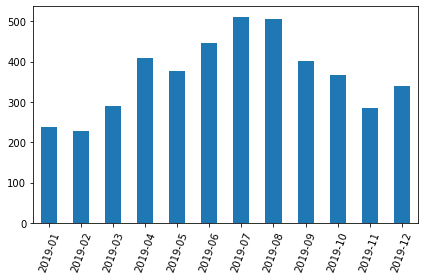

In [71]:
# Monthly solar generation in MWh at 2019 in ERCOT region
monthly_solar = df.groupby(pd.PeriodIndex(df.index, freq="M"))['SolarShape'].sum()
dfsolarMonthly = monthly_solar*dfnormsolar.max()*4/1000 # in GWh

fig, ax = plt.subplots()
dfsolarMonthly.plot.bar(rot=70)
fig.tight_layout()
fig.savefig('monthly_solar.png')

## Compute the monthly averaged historical  Settlement Point Price for the year of 2019

In [3]:
monthly_averages = df.groupby(pd.PeriodIndex(df.index, freq="M"))['Settlement Point Price'].mean()
hourly_averages = df.groupby([df.index.month, df.index.hour])['Settlement Point Price'].mean()
dfavg1 = pd.DataFrame()

for i in range (1,13):
    for j in range (24):
        dftemp=df.loc[(df.index.month==i) & (df.index.hour==j), 'Settlement Point Price'] 
        dfavg1.loc[i-1,j+1] = round(dftemp.mean())
dfavg1.index = ['01', '02', '03', '04','05','06','07','08','09','10','11','12']
dfavg1.loc['Avg'] = round(dfavg1.mean(axis=0))

dfavg1['Avg'] = round(dfavg1.mean(axis=1))
dfavg1 = dfavg1.astype(int)
df_styled = dfavg1.style.background_gradient(axis=None, vmin=10, vmax=50, cmap='coolwarm')
dfi.export(df_styled,"Monthly_Average_Price.png")
dfavg1.to_excel("avgRTM.xlsx")
df_styled

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Avg
01,18,17,17,18,19,22,37,29,30,30,26,26,22,21,21,20,21,32,31,26,26,24,22,19,24
02,18,16,16,17,17,19,34,26,27,35,33,23,22,22,21,20,20,22,31,24,25,24,20,19,23
03,16,15,15,16,19,33,59,29,29,30,28,28,26,28,25,24,25,26,53,30,31,25,20,18,27
04,14,14,13,14,17,43,25,20,25,23,24,23,27,39,37,42,34,32,31,43,24,21,18,17,26
05,16,15,15,16,17,22,20,22,21,25,27,31,42,51,48,39,29,26,27,25,24,21,18,18,26
06,16,15,14,15,16,16,17,18,20,22,25,30,36,41,69,90,48,26,27,23,21,19,18,17,27
07,16,15,14,14,15,16,17,18,19,22,25,45,51,63,88,91,47,27,25,25,22,20,18,18,30
08,15,14,13,13,14,15,16,18,19,22,30,38,164,599,928,828,258,44,26,25,21,19,17,16,132
09,16,15,15,15,16,18,18,20,24,26,28,43,77,121,199,299,99,32,34,27,22,21,18,17,51
10,15,14,13,13,15,33,26,19,20,21,22,24,27,54,124,96,42,25,25,21,22,18,19,16,30


In [4]:
sp1={'Solar Size': 300.0, 'Inverter Capacity': 220.0, 'Solar System Cost': 1.45}

sp2={'Storage Capacity': 50,
 'Storage Energy': 200,
 'Round Trip Efficiency': 0.85,
 'Storage System Cost': 350}

sp3={'Solar Size': 300.0,
 'Inverter Capacity': 220.0,
 'Storage Capacity': 50.0,
 'Storage Energy': 200.0,
 'Round Trip Efficiency': 0.85,
 'Solar System Cost': 1.35,
 'Storage System Cost': 325}

### case 1: Calculate the revenue of Standalone Solar configuration

In [5]:
df['SolarDC'] = df['SolarShape'].values * sp1['Solar Size']
df['SolarAC'] = df['SolarDC'].apply(lambda x: x if x <= sp1['Inverter Capacity'] else sp1['Inverter Capacity'])
df['hour'] = range(0,8760)
df.index = df.hour
results_df = df 
results_df['revenue'] = df.SolarAC * df['Settlement Point Price'] 
serviceLifeSolar = 30

total_revenue = results_df.revenue.sum()
capex = sp1['Solar Size']*sp1['Solar System Cost']*1000000/serviceLifeSolar

print('Annual revenue was ${:,.2f}'.format(total_revenue))
print('Annual cost ${:,.2f}'.format(capex))

Annual revenue was $42,620,516.89
Annual cost $14,500,000.00


### Case 2: Calculate the revenue of Standalone Storage configuration

In [6]:
def optimizeStorage(df, first_model_hour=0, last_model_hour=8759, setup=sp2):
    df = df.loc[first_model_hour:last_model_hour, :]

    model = ConcreteModel()

    # Define model parameters
    model.T = Set(doc='hour of year', initialize=df.hour.tolist(), ordered=True)
    model.Rmax = Param(initialize=setup['Storage Capacity'],
                       doc='Max rate of power flow (MW) in or out')
    model.Smax = Param(initialize=setup['Storage Energy'], doc='Max storage (MWh)')
    model.P = Param(initialize=df['Settlement Point Price'].tolist(), doc='RTMP for each hour')

    # Charge, discharge, and state of charge
    model.Ein = Var(model.T, domain=NonNegativeReals)
    model.Eout = Var(model.T, domain=NonNegativeReals)
    model.S = Var(model.T, bounds=(0, model.Smax))


    #Set all constraints
    def storage_state(model, t):
        'Storage changes with flows in/out and efficiency losses'
        if t == model.T.first():
            return model.S[t] == 0

        else:
            return (model.S[t] == (model.S[t-1] 
                                + (model.Ein[t-1] * np.sqrt(eta)) 
                                - (model.Eout[t-1])))

    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        "Maximum dischage within a single hour"
        return model.Eout[t] <= model.Rmax

    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        "Maximum charge within a single hour"
        return model.Ein[t]*np.sqrt(eta) <= model.Rmax

    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t):
        'Limit discharge to the amount of charge in battery, including losses'
        return model.Eout[t] <= model.S[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    # Define the battery income, expenses, and profit
    income = sum(df.loc[t, 'Settlement Point Price' ] * model.Eout[t]*np.sqrt(eta) for t in model.T)
    expenses = sum(df.loc[t, 'Settlement Point Price'] * model.Ein[t] for t in model.T)
    profit = income - expenses
    model.objective = Objective(expr=profit, sense=maximize)

    # Solve the model
    solver = SolverFactory('glpk')
    solver.solve(model)

    hours = range(model.T[first_model_hour + 1], model.T[last_model_hour + 1] + 1)
    Ein = [value(model.Ein[i]) for i in hours]
    Eout = [value(model.Eout[i]) for i in hours]
    Price = [model.P.extract_values()[None][i] for i in hours]
    charge_state = [value(model.S[i]) for i in hours]

    df_dict = dict(
        hour=hours,
        Ein=Ein,
        Eout=Eout,
        price=Price,
        charge_state=charge_state
    )

    results_df = pd.DataFrame(df_dict)

    results_df['timeStamp'] = df.index

    return results_df

eta = 0.85 # Round trip storage efficiency
results_df = optimizeStorage(df,first_model_hour=0, last_model_hour=8759, setup = sp2)
results_df.to_csv('optimization_resultscase2.csv')


results_df['revenue'] = results_df.Eout*np.sqrt(eta)* results_df.price - results_df.Ein * results_df.price 
total_revenue = results_df.revenue.sum()

serviceLife = 10
capex = sp2['Storage System Cost']*sp2['Storage Energy']*1000/serviceLife

print('Annual revenue was ${:,.2f}'.format(total_revenue))
print('Annual cost ${:,.2f}'.format(capex))

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (P) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    C:\Users\cd7\AppData\Local\Continuum\anaconda3\envs\py39\lib\site-
    packages\pyomo\core\base\indexed_component.py:707)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in 7.0) (called from
    C:\Users\cd7\AppData\Local\Temp/ipykernel_10464/1590877512.py:59)
Annual revenue was $6,910,461.23
Annual cost $7,000,000.00


### Case 3: Calculate the projected backcast 2019 revenue of Solar + Storage configuration
Here, two settings are considered: (1) AC coupled (left), (2) DC coupled (right).

AC coupled  | DC coupled
- | - 
![alt](./Picture1.png) | ![alt](./Picture2.png)

Additional Constraints:

For AC coupled:

$\forall t$, $0<=E_t^{SoutG}+E_t^{Sin}/\sqrt{\eta}<=AC_t$


For DC coupled:

$\forall t$, $0<=E_t^{SoutG}+E_t^{Sin}/\sqrt{\eta}<=DC_t$

$\forall t$, $0<=E_t^{SoutG}+E_t^{BoutG}*\sqrt{\eta}<=220$

In [7]:
def optimizeSolStorage(df, first_model_hour=0, last_model_hour=8759, setup=sp3):
    df = df.loc[first_model_hour:last_model_hour, :]

    model = ConcreteModel()

    # Define model parameters
    model.T = Set(doc='hour of year', initialize=df.hour.tolist(), ordered=True)

    model.Rmax = Param(initialize=setup['Storage Capacity'],
                       doc='Max rate of power flow (MW) in or out')
    model.Smax = Param(initialize=setup['Storage Energy'], doc='Max storage (MWh)')
    model.P = Param(initialize=df['Settlement Point Price'].tolist(), doc='RTMP for each hour')
    eta = 0.85 # Round trip storage efficiency

    # Charge in from grid, discharge out to grid, and state of charge
    model.GinE = Var(model.T, domain=NonNegativeReals)
    model.EoutG = Var(model.T, domain=NonNegativeReals)
    model.S = Var(model.T, bounds=(0, model.Smax))


    # Solar output to grid
    # Solar output to storage
    model.SinE = Var(model.T, domain=NonNegativeReals)
    model.SoutG = Var(model.T, domain=NonNegativeReals)

    model.ACout = Param(initialize=df.SolarAC.tolist(),doc='Solar AC')

    #Set all constraints
    def storage_state(model, t):
        'Storage changes with flows in/out and efficiency losses'
        if t == model.T.first():
            return model.S[t] == 0

        else:
            return (model.S[t] == (model.S[t-1] 
                                + (model.GinE[t-1] ) 
                                + (model.SinE[t-1] ) 
                                - (model.EoutG[t-1])))

    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        "Maximum dischage within a single hour"
        return model.EoutG[t] <= model.Rmax

    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        "Maximum charge within a single hour"
        return (model.GinE[t]+model.SinE[t]) <= model.Rmax

    model.charge = Constraint(model.T, rule=charge_constraint)

    def positive_charge(model, t):
        'Limit discharge to the amount of charge in battery, including losses'
        return model.EoutG[t] <= model.S[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)


    def inverter_limit(model, t):
        'Limit inverter output'
        return model.SoutG[t] + model.SinE[t]/np.sqrt(eta)<=model.ACout.extract_values()[None][t]
 
    model.inverter_limit = Constraint(model.T, rule=inverter_limit)



    # Define the total income, expenses, and profit
    income = sum(df.loc[t, 'Settlement Point Price'] * (model.EoutG[t]*np.sqrt(eta) + model.SoutG[t]) for t in model.T)
    expenses = sum(df.loc[t, 'Settlement Point Price'] * model.GinE[t]/np.sqrt(eta) for t in model.T)
    profit = income - expenses
    model.objective = Objective(expr=profit, sense=maximize)

    # Solve the model
    solver = SolverFactory('glpk')
    solver.solve(model)

    hours = range(model.T[first_model_hour + 1], model.T[last_model_hour + 1] + 1)
    GinE = [value(model.GinE[i]) for i in hours]
    EoutG = [value(model.EoutG[i]) for i in hours]
    SinE = [value(model.SinE[i]) for i in hours]
    SoutG = [value(model.SoutG[i]) for i in hours]    
    Price = [model.P.extract_values()[None][i] for i in hours]
    charge_state = [value(model.S[i]) for i in hours]

    df_dict = dict(
        hour = hours,
        GinE = GinE,
        EoutG = EoutG,
        SinE = SinE,
        SoutG = SoutG,
        price = Price,
        charge_state = charge_state
    )

    results_df = pd.DataFrame(df_dict)

    results_df['timeStamp'] = df.index

    return results_df

results_df = optimizeSolStorage(df,first_model_hour=0, last_model_hour=8759, setup = sp3)
results_df.to_csv('optimization_resultscase3AC.csv')


results_df['revenue'] = (results_df.EoutG*np.sqrt(eta)+ results_df.SoutG)* results_df.price - (results_df.GinE/np.sqrt(eta)) * results_df.price
total_revenue = results_df.revenue.sum()

serviceLifeStorange = 10
serviceLifeSolar = 30

capex = sp3['Storage System Cost']*sp3['Storage Energy']*1000/serviceLifeStorange + sp3['Solar Size']*sp3['Solar System Cost']*1000000/serviceLifeSolar


print('Annual revenue was ${:,.2f}'.format(total_revenue))
print('Annual cost ${:,.2f}'.format(capex))

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (ACout) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    C:\Users\cd7\AppData\Local\Continuum\anaconda3\envs\py39\lib\site-
    packages\pyomo\core\base\indexed_component.py:707)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in 7.0) (called from
    C:\Users\cd7\AppData\Local\Temp/ipykernel_10464/1794385809.py:78)
Annual revenue was $49,533,183.51
Annual cost $20,000,000.00


In [8]:
def optimizeSolStorage(df, first_model_hour=0, last_model_hour=8759, setup=sp3):
    df = df.loc[first_model_hour:last_model_hour, :]

    model = ConcreteModel()

    # Define model parameters
    model.T = Set(doc='hour of year', initialize=df.hour.tolist(), ordered=True)

    model.Rmax = Param(initialize=setup['Storage Capacity'],
                       doc='Max rate of power flow (MW) in or out')
    model.Smax = Param(initialize=setup['Storage Energy'], doc='Max storage (MWh)')
    model.P = Param(initialize=df['Settlement Point Price'].tolist(), doc='RTMP for each hour')
    eta = 0.85 # Round trip storage efficiency

    # Charge in from grid, discharge out to grid, and state of charge
    model.GinE = Var(model.T, domain=NonNegativeReals)
    model.EoutG = Var(model.T, domain=NonNegativeReals)
    model.S = Var(model.T, bounds=(0, model.Smax))


    # Solar output to grid
    # Solar output to storage
    model.SinE = Var(model.T, domain=NonNegativeReals)
    model.SoutG = Var(model.T, domain=NonNegativeReals)

    model.DCout = Param(initialize=df.SolarDC.tolist(),doc='Solar DC')

    #Set all constraints
    def storage_state(model, t):
        'Storage changes with flows in/out and efficiency losses'
        if t == model.T.first():
            return model.S[t] == 0

        else:
            return (model.S[t] == (model.S[t-1] 
                                + (model.GinE[t-1] ) 
                                + (model.SinE[t-1] ) 
                                - (model.EoutG[t-1])))

    model.charge_state = Constraint(model.T, rule=storage_state)

    def discharge_constraint(model, t):
        "Maximum dischage within a single hour"
        return model.EoutG[t] <= model.Rmax

    model.discharge = Constraint(model.T, rule=discharge_constraint)

    def charge_constraint(model, t):
        "Maximum charge within a single hour"
        return  (model.GinE[t]+model.SinE[t]) <= model.Rmax

    model.charge = Constraint(model.T, rule=charge_constraint)

    
    def positive_charge(model, t):
        'Limit discharge to the amount of charge in battery, including losses'
        return model.EoutG[t] <= model.S[t] 
    model.positive_charge = Constraint(model.T, rule=positive_charge)

    def DC_limit(model, t):
        'Limit DC output'
        return (model.SoutG[t] + model.SinE[t]/np.sqrt(eta))<=model.DCout.extract_values()[None][t]

    model.DC_limit = Constraint(model.T, rule=DC_limit)

    def inverter_limit(model, t):
        'Limit inverter output'
        return model.SoutG[t] + model.EoutG[t]*np.sqrt(eta)<=setup['Inverter Capacity']

    model.inverter_limit = Constraint(model.T, rule=inverter_limit)

    # Define the total income, expenses, and profit
    income = sum(df.loc[t, 'Settlement Point Price'] * (model.EoutG[t]*np.sqrt(eta)+ model.SoutG[t]) for t in model.T)
    expenses = sum(df.loc[t, 'Settlement Point Price'] * model.GinE[t]/np.sqrt(eta) for t in model.T)
    profit = income - expenses
    model.objective = Objective(expr=profit, sense=maximize)

    # Solve the model
    solver = SolverFactory('glpk')
    solver.solve(model)

    hours = range(model.T[first_model_hour + 1], model.T[last_model_hour + 1] + 1)
    GinE = [value(model.GinE[i]) for i in hours]
    EoutG = [value(model.EoutG[i]) for i in hours]
    SinE = [value(model.SinE[i]) for i in hours]
    SoutG = [value(model.SoutG[i]) for i in hours]    
    Price = [model.P.extract_values()[None][i] for i in hours]
    charge_state = [value(model.S[i]) for i in hours]

    df_dict = dict(
        hour = hours,
        GinE = GinE,
        EoutG = EoutG,
        SinE = SinE,
        SoutG = SoutG,
        price = Price,
        charge_state = charge_state
    )

    results_df = pd.DataFrame(df_dict)

    results_df['timeStamp'] = dti

    return results_df

results_df = optimizeSolStorage(df,first_model_hour=0, last_model_hour=8759, setup = sp3)

results_df.to_csv('optimization_resultscase3DC.csv')


results_df['revenue'] = (results_df.EoutG*np.sqrt(eta)+ results_df.SoutG)* results_df.price - (results_df.GinE/np.sqrt(eta)) * results_df.price  
total_revenue = results_df.revenue.sum()

serviceLifeStorange = 10
serviceLifeSolar = 30

capex = sp3['Storage System Cost']*sp3['Storage Energy']*1000/serviceLifeStorange + sp3['Solar Size']*sp3['Solar System Cost']*1000000/serviceLifeSolar


print('Annual revenue was ${:,.2f}'.format(total_revenue))
print('Annual cost ${:,.2f}'.format(capex))



    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (DCout) to be 'Any', you can suppress this
    warning by explicitly specifying 'within=Any' to the Param constructor.
    (deprecated in 5.6.9, will be removed in 6.0) (called from
    C:\Users\cd7\AppData\Local\Continuum\anaconda3\envs\py39\lib\site-
    packages\pyomo\core\base\indexed_component.py:707)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in 7.0) (called from
    C:\Users\cd7\AppData\Local\Temp/ipykernel_10464/2858984879.py:82)
Annual revenue was $44,888,953.79
Annual cost $20,000,000.00


##  Using Gurobipy

(1) for the standalone storage system, it is an optimization problem (energy arbitrage).

In [9]:
import gurobipy as gp
from gurobipy import GRB

In [10]:
# Parameters

nhours = 8760
StorageCapacity = 50
StorageEnergy = 200
rtm = df['Settlement Point Price'].tolist()
timeh = range(nhours)

In [11]:
eta = 0.85
# Create a new model
m = gp.Model ("solarPlan")
# Create variables
eOut = m.addVars(timeh,  vtype = GRB.CONTINUOUS, name ="eout")
eIn = m.addVars (timeh,  vtype = GRB.CONTINUOUS , name ="ein")
soc = m.addVars (timeh, ub=StorageEnergy, vtype = GRB.CONTINUOUS, name ="soc")

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-17


## Set constraints

In [12]:
start_state = m.addConstrs((soc[t] == 0 for t in timeh  if t==0),'SOCst')
storage_state = m.addConstrs(( soc[t] == (soc[t-1] 
                                + (eIn[t-1] * np.sqrt(eta)) 
                                - (eOut[t-1])) for t in timeh[1:]),'SOC')

In [13]:
discharge_state = m.addConstrs((eOut[t] <= StorageCapacity for t in timeh),'discharge_st')

charge_state = m.addConstrs( (eIn[t]* np.sqrt(eta) <= StorageCapacity for t in timeh),'charge_st')

positive_charge = m.addConstrs( (eOut[t] <= soc[t] for t in timeh),'poscharge')

In [14]:
### Define the battery income, expenses, and profit
# Set objective
m.setObjective(sum(rtm[t]*(eOut[t]* np.sqrt(eta) - eIn[t]) for t in timeh), GRB.MAXIMIZE)

In [15]:
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 35040 rows, 26280 columns and 70077 nonzeros
Model fingerprint: 0x24ecae74
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [9e-03, 9e+03]
  Bounds range     [2e+02, 2e+02]
  RHS range        [5e+01, 5e+01]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 17527 rows and 8 columns
Presolve time: 0.11s
Presolved: 17513 rows, 26272 columns, 52544 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.627e+04
 Factor NZ  : 2.188e+05 (roughly 20 MB of memory)
 Factor Ops : 3.439e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.44549874e+06  1.65837950e+10  2.24e+00 8.00e+03  4.64e+05     0s
   1  -6.19061436e+05  

### Case 3 AC

In [16]:
m = gp.Model ("solarPlanAC")

In [17]:
# add additional Parameters
# solarCost = 1.35
# batteryCost = 350
ACout =  df.SolarAC.tolist()

In [18]:
# Create variables
GInB = m.addVars(timeh, lb=0, vtype = GRB.CONTINUOUS , name ="GinB")
SinB = m.addVars(timeh, lb=0, vtype = GRB.CONTINUOUS, name ="SinB")
BoutG = m.addVars(timeh, lb=0, vtype = GRB.CONTINUOUS, name ="BoutG")
SoutG = m.addVars(timeh, lb=0, vtype = GRB.CONTINUOUS, name ="SoutG")
soc = m.addVars (timeh, lb=0, ub=StorageEnergy, vtype = GRB.CONTINUOUS, name ="soc")

### constraints

In [19]:
start_state = m.addConstrs((soc[t] == 0 for t in timeh  if t==0),'SOCst')
storage_state = m.addConstrs(( soc[t] == (soc[t-1] 
                                + (GInB[t-1]+SinB[t-1])
                                - (BoutG[t-1])) for t in timeh[1:]),'SOC')

In [20]:
discharge_state = m.addConstrs((BoutG[t] <= StorageCapacity for t in timeh),'discharge_st')

charge_state = m.addConstrs( ((GInB[t]+SinB[t]) <= StorageCapacity for t in timeh),'charge_st')

positive_charge = m.addConstrs((BoutG[t] <= soc[t] for t in timeh),'poscharge')

AC_lim = m.addConstrs((SoutG[t]+SinB[t]/np.sqrt(eta) <= ACout[t]  for t in timeh),'poscharge')

In [21]:
### Define the battery income, expenses, and profit
# Set objective
m.setObjective(sum(rtm[t]*(BoutG[t]*np.sqrt(eta)+ SoutG[t]-GInB[t]/np.sqrt(eta)) for t in timeh), GRB.MAXIMIZE)
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 43800 rows, 43800 columns and 105116 nonzeros
Model fingerprint: 0x7599f007
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-03, 1e+04]
  Bounds range     [2e+02, 2e+02]
  RHS range        [3e-07, 2e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 26287 rows and 17528 columns
Presolve time: 0.16s
Presolved: 17513 rows, 26272 columns, 52544 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.627e+04
 Factor NZ  : 2.188e+05 (roughly 20 MB of memory)
 Factor Ops : 3.439e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.94819067e+07  1.73971051e+10  2.45e+01 1.02e+03  4.85e+05     0s
   1   4.19588304e

### Case 3 DC

In [22]:
m = gp.Model ("solarPlanDC")
# add additional Parameters
DCout =  df.SolarDC.tolist()
InverterCapacity = 220

In [23]:
# Create variables
GInB = m.addVars(timeh, lb=0, vtype = GRB.CONTINUOUS , name ="GinB")
SinB = m.addVars(timeh, lb=0, vtype = GRB.CONTINUOUS, name ="SinB")
BoutG = m.addVars(timeh, lb=0, vtype = GRB.CONTINUOUS, name ="BoutG")
SoutG = m.addVars(timeh, lb=0, vtype = GRB.CONTINUOUS, name ="SoutG")
soc = m.addVars (timeh, lb=0, ub=StorageEnergy, vtype = GRB.CONTINUOUS, name ="soc")

In [24]:
start_state = m.addConstrs((soc[t] == 0 for t in timeh  if t==0),'SOCst')
storage_state = m.addConstrs(( soc[t] == (soc[t-1] 
                                + (GInB[t-1]+SinB[t-1])
                                - (BoutG[t-1])) for t in timeh[1:]),'SOC')

In [25]:
discharge_state = m.addConstrs((BoutG[t] <= StorageCapacity for t in timeh),'discharge_st')

charge_state = m.addConstrs( ((GInB[t]+SinB[t])<= StorageCapacity for t in timeh),'charge_st')

positive_charge = m.addConstrs((BoutG[t] <= soc[t] for t in timeh),'poscharge')

dc_lim = m.addConstrs((SoutG[t]+SinB[t]/np.sqrt(eta) <= DCout[t]  for t in timeh),'poscharge')

inverter_lim =  m.addConstrs((SoutG[t]+BoutG[t]*np.sqrt(eta) <= InverterCapacity  for t in timeh),'poscharge')

In [26]:
### Define the battery income, expenses, and profit
# Set objective
m.setObjective(sum(rtm[t]*(BoutG[t]*np.sqrt(eta)+ SoutG[t]-GInB[t]/np.sqrt(eta)) for t in timeh), GRB.MAXIMIZE)
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 52560 rows, 43800 columns and 122636 nonzeros
Model fingerprint: 0xdd3430de
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [9e-03, 1e+04]
  Bounds range     [2e+02, 2e+02]
  RHS range        [3e-07, 3e+02]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 28786 rows and 13354 columns
Presolve time: 0.16s
Presolved: 23774 rows, 30446 columns, 67153 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.879e+04
 Factor NZ  : 2.424e+05 (roughly 24 MB of memory)
 Factor Ops : 3.422e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.64605493e+07  6.95990520e+09  2.31e+02 3.17e+03  2.40e+06     0s
   1   2.88805208e